## GPU Configuration and Imports <a class="anchor" id="GPU-Configuration-and-Imports"></a>

In [1]:
import os
import tensorflow as tf
import sys
print(sys.version)
print(sys.executable)
print(sys.version_info)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # 0,1,2,3
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')

print(gpus)

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Error loading GPU:", e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

2025-03-15 10:25:33.576151: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-15 10:25:34.375150: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-15 10:25:34.375221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-15 10:25:34.522232: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-15 10:25:34.816120: I tensorflow/core/platform/cpu_feature_guar

3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]
/home/ubuntu/miniconda3/bin/python
sys.version_info(major=3, minor=11, micro=4, releaselevel='final', serial=0)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-03-15 10:25:41.136412: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-15 10:25:41.561647: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-15 10:25:41.563844: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, LayerNormalization, Dense, ReLU
from tensorflow.nn import relu

from sionna.channel.tr38901 import Antenna, AntennaArray, CDL
from sionna.channel import OFDMChannel
from sionna.mimo import StreamManagement
from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer, RemoveNulledSubcarriers, ResourceGridDemapper
from sionna.utils import BinarySource, ebnodb2no, insert_dims, flatten_last_dims, log10, expand_to_rank
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mapping import Mapper, Demapper, Constellation
from sionna.utils.metrics import compute_ber
from sionna.utils import sim_ber, hard_decisions

from tqdm.auto import tqdm

## Simulation Parameters <a class="anchor" id="Simulation-Parameters"></a>

In [4]:
# ## Channel configuration
carrier_frequency = 3.5e9 # Hz
delay_spread = 100e-9 # s
cdl_model = "C" # CDL model to use
speed = 10.0 # Speed for evaluation and training [m/s]
# SNR range for evaluation and training [dB]
ebno_db_min = 0.0
ebno_db_max = 10.0

############################################
## OFDM waveform configuration
subcarrier_spacing = 30e3 # Hz
fft_size = 128 # Number of subcarriers forming the resource grid, including the null-subcarrier and the guard bands
num_ofdm_symbols = 14 # Number of OFDM symbols forming the resource grid
dc_null = True # Null the DC subcarrier
num_guard_carriers = [5, 6] # Number of guard carriers on each side
pilot_pattern = "kronecker" # Pilot pattern
pilot_ofdm_symbol_indices = [2, 11] # Index of OFDM symbols carrying pilots
cyclic_prefix_length = 0 # Simulation in frequency domain. This is useless

############################################
## Modulation and coding configuration
num_bits_per_symbol = 6 # 64-QAM
coderate = 0.5 # Coderate for LDPC code
noise_dim = 100

############################################
## Neural receiver configuration
num_conv_channels = 128 # Number of convolutional channels for the convolutional layers forming the neural receiver
GAN_DIM=64

############################################
## Training configuration
num_training_iterations = 50000 # Number of training iterations
training_batch_size = 128 # Training batch size
model_weights_path_standard = "neural_receiver_weights_standard" # Location to save the neural receiver weights once training is done
model_weights_path_trained = "neural_receiver_weights_trained"

############################################
## Evaluation configuration
results_filename = "neural_receiver_results" # Location to save the results

In [5]:
stream_manager = StreamManagement(np.array([[1]]), # Receiver-transmitter association matrix
                                  1)               # One stream per transmitter

In [6]:
resource_grid = ResourceGrid(num_ofdm_symbols = num_ofdm_symbols,
                             fft_size = fft_size,
                             subcarrier_spacing = subcarrier_spacing,
                             num_tx = 1,
                             num_streams_per_tx = 1,
                             cyclic_prefix_length = cyclic_prefix_length,
                             dc_null = dc_null,
                             pilot_pattern = pilot_pattern,
                             pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices,
                             num_guard_carriers = num_guard_carriers)

2025-03-15 10:25:43.371947: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-15 10:25:43.373860: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-15 10:25:43.375497: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
# Codeword length. It is calculated from the total number of databits carried by the resource grid, and the number of bits transmitted per resource element
# data symbols = 1392
n = int(resource_grid.num_data_symbols*num_bits_per_symbol)
# Number of information bits per codeword
k = int(n*coderate)
print(n)
print(k)

8352
4176


In [8]:
ut_antenna = Antenna(polarization="single",
                     polarization_type="V",
                     antenna_pattern="38.901",
                     carrier_frequency=carrier_frequency)

bs_array = AntennaArray(num_rows=1,
                        num_cols=1,
                        polarization="single", # dual
                        polarization_type="V", # VH
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)

## Resource Grid Util

In [9]:
class ModifiedResourceGridMapper(Layer):
    def __init__(self, resource_grid, dtype=tf.complex64, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self._resource_grid = resource_grid
        self._rg_type = self._resource_grid.build_type_grid()
        self._pilot_ind = tf.where(self._rg_type == 1)  # Indices for pilots

    def extract_pilots(self, input_rg):
        input_rg = tf.squeeze(input_rg, axis=1)
        
        pilot_grid = tf.zeros_like(input_rg)
        pilot_values = tf.gather_nd(input_rg, self._pilot_ind)
        pilot_grid = tf.tensor_scatter_nd_update(pilot_grid, self._pilot_ind, pilot_values)
        
        pilot_grid = tf.expand_dims(pilot_grid, axis=1)
        
        return pilot_grid

    def replace(self, inputs):
        # Unpack the generated and real resource grids
        generated_y_rg, real_y_rg = inputs  # (batch, 1, 2, ofdm, subcar)

        generated_y_rg = tf.squeeze(generated_y_rg, axis=1)
        real_y_rg = tf.squeeze(real_y_rg, axis=1)

        # Extract the pilots from the real resource grid
        real_pilots = tf.gather_nd(real_y_rg, self._pilot_ind)

        # Replace the pilots in the generated resource grid with the real pilots
        updated_y_rg = tf.tensor_scatter_nd_update(generated_y_rg, self._pilot_ind, real_pilots)
        updated_y_rg = tf.expand_dims(updated_y_rg, axis=1)  # Restore dimensions

        return updated_y_rg

## Neural Receiver <a class="anchor" id="Neural-Receiver"></a>

In [10]:
class ResidualBlock(Layer):
    def __init__(self, name=None, **kwargs):
        super(ResidualBlock, self).__init__(name=name, **kwargs)
    
        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_1 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_1 = Conv2D(filters=num_conv_channels,
                              kernel_size=[3,3],
                              padding='same',
                              activation=None)
        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_2 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_2 = Conv2D(filters=num_conv_channels,
                              kernel_size=[3,3],
                              padding='same',
                              activation=None)

    def call(self, inputs):
        z = self._layer_norm_1(inputs)
        z = relu(z)
        z = self._conv_1(z)
        z = self._layer_norm_2(z)
        z = relu(z)
        z = self._conv_2(z) # [batch size, num time samples, num subcarriers, num_channels]
        # Skip connection
        z = z + inputs

        return z

class NeuralReceiver(Model):
    def __init__(self, **kwargs):
        super(NeuralReceiver, self).__init__(**kwargs)
        self.receiver = self.build_receiver()
    
    def build_receiver(self):
        self._input_conv = Conv2D(filters=num_conv_channels,
                                  kernel_size=[3,3],
                                  padding='same',
                                  activation=None,
                                 name="neural_receiver_input_conv")
        self._output_conv = Conv2D(filters=num_bits_per_symbol,
                                   kernel_size=[3,3],
                                   padding='same',
                                   activation=None,
                                  name="neural_receiver_output_conv")

        inputs = tf.keras.Input(shape=(14, 128, 3))
        # Input conv
        z = self._input_conv(inputs)
        # Residual blocks
        z = ResidualBlock(name="neural_receiver_residual_block_1")(z)
        z = ResidualBlock(name="neural_receiver_residual_block_2")(z)
        z = ResidualBlock(name="neural_receiver_residual_block_3")(z)
        z = ResidualBlock(name="neural_receiver_residual_block_4")(z)
        # Output conv
        z = self._output_conv(z)
        
        return tf.keras.Model(inputs=inputs, outputs=z, name="Neural_receiver")

    def call(self, inputs):
        y, no = inputs

        # Feeding the noise power in log10 scale helps with the performance
        no = log10(no)

        # Stacking the real and imaginary components of the different antennas along the 'channel' dimension
        y = tf.transpose(y, [0, 2, 3, 1]) # Putting antenna dimension last
        no = insert_dims(no, 3, 1)
        no = tf.tile(no, [1, y.shape[1], y.shape[2], 1])
        # z : [batch size, num ofdm symbols, num subcarriers, 2*num rx antenna + 1]
        z = tf.concat([tf.math.real(y),
                       tf.math.imag(y),
                       no], axis=-1)

        z = self.receiver(z)

        return z

In [11]:
NR = NeuralReceiver()
NR.receiver.summary()

Model: "Neural_receiver"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 128, 3)]      0         
                                                                 
 neural_receiver_input_conv  (None, 14, 128, 128)      3584      
  (Conv2D)                                                       
                                                                 
 neural_receiver_residual_b  (None, 14, 128, 128)      1212672   
 lock_1 (ResidualBlock)                                          
                                                                 
 neural_receiver_residual_b  (None, 14, 128, 128)      1212672   
 lock_2 (ResidualBlock)                                          
                                                                 
 neural_receiver_residual_b  (None, 14, 128, 128)      1212672   
 lock_3 (ResidualBlock)                            

## Conv2D GAN

In [12]:
class GANGenerator(tf.keras.Model):
    def __init__(self, **kwargs):
        super(GANGenerator, self).__init__(**kwargs)
        self.generator = self.build_generator()

    def build_generator(self):
        """Builds the generator model."""
        x_real_input = tf.keras.layers.Input(shape=(14,128,2))  # (batch,14,128,2)
        noise_input = tf.keras.layers.Input(shape=(14,128,noise_dim)) 
        h_input = tf.keras.layers.Input(shape=(14,128,2))  # (batch,14,128,2)
        
        x = tf.keras.layers.Concatenate()([x_real_input, noise_input, h_input])

        x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', use_bias=False)(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', use_bias=False)(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', use_bias=False)(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Conv2D(filters=2, kernel_size=(3, 3), padding='same', use_bias=False)(x)
        
        return  tf.keras.Model(inputs=[x_real_input, noise_input, h_input], outputs=x, name="GANChannel_Generator")
    
    def call(self, z, x, h):
        x = tf.squeeze(x, axis=[1,2])
        
        x_real, x_imag = tf.math.real(x), tf.math.imag(x) # [batch,14,128]
        x_flat = tf.stack([x_real, x_imag], axis=-1) #  [batch,14,128,2]

        h = tf.squeeze(h, axis=[1,2,3,4])
        h_real, h_imag = tf.math.real(h), tf.math.imag(h) # [batch,14,128]
        h_flat = tf.stack([h_real, h_imag], axis=-1) #  [batch,14,128,2]
        
        y = self.generator([x_flat, z, h_flat]) # [batch,14,128,2]

        y_r, y_i = y[:,:,:,0], y[:,:,:,1] 
        y_complex = tf.complex(y_r, y_i)
        
        y_complex = tf.expand_dims(y_complex, axis=1)
        y_complex = tf.expand_dims(y_complex, axis=1)
        
        return y_complex

In [13]:
gan_generator = GANGenerator()
gan_generator.generator.summary()

Model: "GANChannel_Generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 14, 128, 2)]         0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 14, 128, 100)]       0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 14, 128, 2)]         0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 14, 128, 104)         0         ['input_2[0][0]',             
                                                                     'input_3[0

In [14]:
class GANDiscriminator(tf.keras.Model):
    def __init__(self, **kwargs):
        super(GANDiscriminator, self).__init__(**kwargs)
        self.discriminator = self.build_discriminator()
    
    def build_discriminator(self):
        """Builds the discriminator model."""
        y_rg = tf.keras.layers.Input(shape=(14,128,6))

        y = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same')(y_rg)
        y = tf.keras.layers.LeakyReLU()(y)
        # y = tf.keras.layers.Dropout(0.3)(y)
        y = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same')(y)
        # y = tf.keras.layers.LayerNormalization()(y)
        y = tf.keras.layers.LeakyReLU()(y)
        # y = tf.keras.layers.Dropout(0.3)(y)
        y = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same')(y)
        # y = tf.keras.layers.LayerNormalization()(y)
        y = tf.keras.layers.LeakyReLU()(y)
        # y = tf.keras.layers.Dropout(0.3)(y)

        y = tf.keras.layers.Flatten()(y)
        # FC = tf.nn.relu(tf.keras.layers.Dense(100, activation=None)(FC))
        D_logit = tf.keras.layers.Dense(1, activation='linear')(y) # sigmoid
        # D_prob = tf.nn.sigmoid(conv4)
        
        return tf.keras.Model(inputs=y_rg, outputs=D_logit, name="GANChannel_Discriminator")
    
    def call(self, y, x, h):
        y = tf.squeeze(y, axis=[1,2])
        y_real, y_imag = tf.math.real(y), tf.math.imag(y) # [batch,14,128]
        y_cat = tf.stack([y_real, y_imag], axis=-1) # [batch,14,128,2]

        x = tf.squeeze(x, axis=[1,2])
        x_real, x_imag = tf.math.real(x), tf.math.imag(x) # [batch,14,128]
        x_cat = tf.stack([x_real, x_imag], axis=-1) # [batch,14,128,2]

        h = tf.squeeze(h, axis=[1,2,3,4])
        h_real, h_imag = tf.math.real(h), tf.math.imag(h) # [batch,14,128]
        h_cat = tf.stack([h_real, h_imag], axis=-1) #  [batch,14,128,2]
        
        cat = tf.concat([y_cat, x_cat, h_cat], axis=-1) # [batch,14,128,4]

        y_logit = self.discriminator(cat)
        
        return y_logit

In [15]:
gan_discriminator = GANDiscriminator()
gan_discriminator.discriminator.summary()

Model: "GANChannel_Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 14, 128, 6)]      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 128, 64)       3520      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 128, 64)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 128, 128)      73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 128, 128)      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 128, 256)      295168    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 12

## End-to-end System <a class="anchor" id="End-to-end-System"></a>

In [16]:
## Transmitter
binary_source = BinarySource()
# mapper = Mapper("qam", num_bits_per_symbol)
# rg_mapper = ResourceGridMapper(resource_grid)

constellation = Constellation("qam", num_bits_per_symbol, trainable=True)
mapper = Mapper(constellation=constellation)
rg_mapper = ResourceGridMapper(resource_grid)

## Channel
cdl = CDL(cdl_model, delay_spread, carrier_frequency,
          ut_antenna, bs_array, "uplink", min_speed=speed)
channel = OFDMChannel(cdl, resource_grid, normalize_channel=True, return_channel=True)

## Receiver
neural_receiver = NeuralReceiver()
rg_demapper = ResourceGridDemapper(resource_grid, stream_manager) # Used to extract data-carrying resource elements

# resource grid helper
rg_util = ModifiedResourceGridMapper(resource_grid)

### Test Definition

In [17]:
batch_size = 128
ebno_db = tf.fill([batch_size], 5.0)
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
z = tf.random.normal(shape=(batch_size, 1, 14, 128))

## Transmitter
c = binary_source([batch_size, 1, 1, n])
print("c shape: ", c.shape)

# Map bits to QAM symbols
x = mapper(c)
print("x shape: ", x.shape)

# Map the QAM symbols to a resource grid
x_rg = rg_mapper(x)
print("x_rg shape: ", x_rg.shape)

######################################
## Channel
# A batch of new channel realizations is sampled and applied at every inference
no_ = expand_to_rank(no, tf.rank(x_rg))
y,_ = channel([x_rg, no_])
print("y shape: ", y.shape)
y_p = rg_util.extract_pilots(y)
print("y_p shape: ", y_p.shape)

######################################
## Receiver
# The neural receover computes LLRs from the frequency domain received symbols and N0
y = tf.squeeze(y, axis=1)
llr = neural_receiver([y, no])
print("llr shape: ", llr.shape)
# Reshape the input to fit what the resource grid demapper is expected
llr = insert_dims(llr, 2, 1)
# Extract data-carrying resource elements. The other LLRs are discarded
llr = rg_demapper(llr)
llr = tf.reshape(llr, [batch_size, 1, 1, n])
print("Post RG-demapper LLRs: ", llr.shape)

c shape:  (128, 1, 1, 8352)
x shape:  (128, 1, 1, 1392)
x_rg shape:  (128, 1, 1, 14, 128)
y shape:  (128, 1, 1, 14, 128)
y_p shape:  (128, 1, 1, 14, 128)


2025-03-15 10:25:56.797676: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-03-15 10:25:57.208249: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


llr shape:  (128, 14, 128, 6)
Post RG-demapper LLRs:  (128, 1, 1, 8352)


In [18]:
bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
bce = tf.reduce_mean(bce)
rate = tf.constant(1.0, tf.float32) - bce/tf.math.log(2.)
print(f"Rate: {rate:.2E} bit")

Rate: -6.05E-01 bit


## End-to-end System as a Keras Model <a class="anchor" id="End-to-end-System-as-a-Keras-Model"></a>

In [28]:
class E2ESystem(Model):
    def __init__(self, training=False):
        super().__init__()
        self._training = training
        self.x_rg = None
        self.y_gen = None
        self.y_real = None
        self.h_freq = None
        self.prior_constellation = None
        self.post_constellation = None
        # self.ls_estimator = LSChannelEstimator(resource_grid, interpolation_type="nn")

        ######################################
        ## Transmitter
        self._binary_source = BinarySource()
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        if not training:
            self._encoder = LDPC5GEncoder(k, n)
            
        # Trainable constellation
        constellation = Constellation("qam", num_bits_per_symbol, trainable=True)
        self.constellation = constellation
        self._mapper = Mapper(constellation=constellation)
        self._rg_mapper = ResourceGridMapper(resource_grid)         

        ######################################
        ## Channel
        # A 3GPP CDL channel model is used
        cdl = CDL(cdl_model, delay_spread, carrier_frequency,
                  ut_antenna, bs_array, "uplink", min_speed=speed)
        self._real_channel = OFDMChannel(cdl, resource_grid, normalize_channel=True, return_channel=True)

        self._gan_channel = GANGenerator()

        ######################################
        ## Receiver
        self._neural_receiver = NeuralReceiver()
        self._rg_demapper = ResourceGridDemapper(resource_grid, stream_manager) # Used to extract data-carrying resource elements
            
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        if not training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)
    
    @tf.function
    def call(self, batch_size, ebno_db, use_gan_channel=False):
        
        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)

        ######################################
        ## Transmitter
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        
        # Outer coding is only performed if not training
        if self._training:
            c = self._binary_source([batch_size, 1, 1, n])
        else:
            b = self._binary_source([batch_size, 1, 1, k])
            c = self._encoder(b)
        
        # c = self._binary_source([batch_size, 1, 1, n]) # for uncoded simulation
        
        # Modulation
        self.prior_constellation = c
        x = self._mapper(c)
        self.post_constellation = x
        
        x_rg = self._rg_mapper(x)

        self.x_rg = x_rg

        ######################################
        ## Channel
        # A batch of new channel realizations is sampled and applied at every inference
        no_ = expand_to_rank(no, tf.rank(x_rg))
        y,h = self._real_channel([x_rg, no_])

        self.y_real = y

        ### ----------------- GAN channel
        if use_gan_channel: 
            out_list = []
            z = tf.random.normal([batch_size, 14, 128, noise_dim])        
            y = self._gan_channel(z, x_rg, h)
            self.h_freq = h
            self.y_gen = y
            
        ######################################
        ## Receiver    
        # The neural receover computes LLRs from the frequency domain received symbols and N0
        y = tf.squeeze(y, axis=1)
        llr = self._neural_receiver([y, no])
        llr = insert_dims(llr, 2, 1) # Reshape the input to fit what the resource grid demapper is expected
        llr = self._rg_demapper(llr) # Extract data-carrying resource elements. The other LLrs are discarded
        llr = tf.reshape(llr, [batch_size, 1, 1, n]) # Reshape the LLRs to fit what the outer decoder is expected

        # Outer coding is not needed if the information rate is returned
        if self._training:
            # Compute and return BMD rate (in bit), which is known to be an achievable
            # information rate for BICM systems. Training aims at maximizing the BMD rate
            bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
            bce = tf.reduce_mean(bce)
            rate = tf.constant(1.0, tf.float32) - bce/tf.math.log(2.)
            if use_gan_channel:
                return rate, self.x_rg, self.y_gen, self.y_real, self.h_freq
            else:
                return rate
        else:
            # Outer decoding
            b_hat = self._decoder(llr)
            return b,b_hat
            # probabilities = tf.math.sigmoid(llr)
            # b_hat = tf.cast(probabilities > 0.5, dtype=tf.float32) # 0.5-1 is False=bit 0; 0-0.5 is True=bit 1 
            # return c,b_hat # Ground truth and reconstructed information bits returned for BER/BLER computation

## PSD

In [22]:
def compute_psd_line(y):
    y = tf.squeeze(y, axis=[1,2])
    fft_result = tf.signal.fft(y)  # Shape: [batch, 14, 128]
    power_db = 20 * tf.math.log(tf.abs(fft_result) + 1e-10) / tf.math.log(10.0)  # Convert to dB
    power_db_shifted = tf.signal.fftshift(power_db, axes=[-1])  # Shape: [batch, 14, 128]
    return tf.reduce_mean(power_db_shifted, axis=1)  # Shape: [batch, 128]

def plot_psd_line(psd_real, psd_fake):
    # Convert to NumPy and average over batch
    psd_real_np = psd_real.numpy().mean(axis=0)  # Shape: [128]
    psd_fake_np = psd_fake.numpy().mean(axis=0)  # Shape: [128]
    
    # Frequency axis (normalized subcarriers)
    freq_axis = np.linspace(-0.5, 0.5, psd_real_np.shape[-1])  # Normalized frequencies
    # Plot
    plt.figure(figsize=(8, 2))
    plt.plot(freq_axis, psd_real_np, label="Real PSD", linewidth=2)
    plt.plot(freq_axis, psd_fake_np, label="Generated PSD", linewidth=2)
    plt.xlabel("Normalized Frequency")
    plt.ylabel("PSD (dB)")
    plt.title("Power Spectral Density of OFDM Signal")
    plt.legend()
    plt.grid()
    plt.show()

def compute_psd(y):
    y = tf.squeeze(y, axis=[1,2])
    # fft_result = tf.signal.fft2d(y)
    # power = tf.abs(fft_result)**2
    fft_result = tf.signal.fft(y) 
    power_db = 20 * tf.math.log(tf.abs(fft_result) + 1e-10) / tf.math.log(10.0)  # Convert to dB
    power = tf.signal.fftshift(power_db, axes=[-1])  # Shape: [batch, 14, 128]
    # Average over the batch dimension
    psd = tf.reduce_mean(power, axis=0)  # Shape: [14, 128]
    
    return psd

def plot_psd(psd_real, psd_generated):
    vmin = min(np.min(psd_real.numpy()), np.min(psd_generated.numpy()))
    vmax = max(np.max(psd_real.numpy()), np.max(psd_generated.numpy()))

    plt.figure(figsize=(12, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(psd_real.numpy(), cmap='jet', aspect='auto', vmin=vmin, vmax=vmax)
    plt.title('Real PSD')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(psd_generated.numpy(), cmap='jet', aspect='auto', vmin=vmin, vmax=vmax)
    plt.title('Generated PSD')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

In [23]:
def plot_phase_amp_distribution(real_y, generated_y):
    phase_real = tf.math.angle(real_y).numpy().flatten()
    phase_fake = tf.math.angle(generated_y).numpy().flatten()

    plt.figure(figsize=(7, 3))
    plt.subplot(1, 2, 1)
    bins = np.linspace(-np.pi, np.pi, 50)
    plt.hist(phase_real, bins=bins, alpha=0.5, label="Real", density=True)
    plt.hist(phase_fake, bins=bins, alpha=0.5, label="Generated", density=True)
    plt.xlabel("Phase (radians)")
    plt.ylabel("Density")
    plt.title("Phase Distribution")
    plt.legend()
    plt.grid()
    
    real_amplitude = np.abs(real_y).flatten()
    gen_amplitude = np.abs(generated_y).flatten()
    
    plt.subplot(1, 2, 2)  
    all_data = np.concatenate((real_amplitude, gen_amplitude))
    bins = np.linspace(np.min(all_data), np.max(all_data), 50)  # Define bins properly
    plt.hist(real_amplitude, bins=bins, density=True, alpha=0.5, color='blue', label='Real')
    plt.hist(gen_amplitude, bins=bins, density=True, alpha=0.5, color='red', label='Generated')
    plt.xlabel("Amplitude")
    plt.ylabel("Density")
    plt.title("Amplitude Distribution")
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()

## Training the WGAN

In [30]:
# Range of SNRs over which the systems are evaluated
ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
                     ebno_db_max, # Max SNR for evaluation
                     0.5) # Step

# Dictionnary storing the evaluation results
BLER = {}
BER = {}

In [31]:
def gradient_penalty(disc, y_real, y_fake, x_real, h):
    lamb = 10
    batchlen = tf.shape(y_real)[0]  # batch size of y_real or y_fake
    
    epsilon = tf.random.uniform([batchlen, 1,1,1,1], minval=0, maxval=1, dtype=tf.float32) # interpolation factor (0-1)
    # epsilon = epsilon[:, None, None, None, None]
    
    # Interpolating between real and fake post-fft y
    y_real = tf.cast(y_real, tf.float32)
    y_fake = tf.cast(y_fake, tf.float32)
    interpolated = epsilon * y_real + (1 - epsilon) * y_fake
    
    # Gradient calculation
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        D_logit_pred = disc(interpolated, x_real, h)

    grads = gp_tape.gradient(D_logit_pred, interpolated)

    # num_elements = tf.reduce_prod(tf.shape(grads)[1:])
    grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1,2,3,4])) # / tf.cast(num_elements, tf.float32) )
    # print(tf.reduce_mean(grads), tf.reduce_mean(grad_norms))
    
    gp = lamb * tf.reduce_mean(tf.square(grad_norms - 1))
    # gp = lamb * tf.reduce_mean(tf.clip_by_value(grad_norms - 1., 0., np.infty)**2)
    
    return gp, tf.reduce_mean(grad_norms)

In [39]:
# -------- only rerun this cell if need to reset training
model = E2ESystem(training=True)
eval_model = E2ESystem(training=False)

WG = GANGenerator()
WD = GANDiscriminator()

list_D = []
list_G = []

# Parameters
lr = 0.0001
epoch = 1000 # best result is 3000, update ratio for every 1000 is 1:1, 1:2, 1:2
snr_db = 10.0  # in dB

optimizer_G = tf.keras.optimizers.Adam(lr, beta_1=0.5, beta_2=0.9)
optimizer_D = tf.keras.optimizers.Adam(lr, beta_1=0.5, beta_2=0.9)

# # offset
# model(batch_size, tf.constant(10.0, tf.float32), use_gan_channel=True)
# with open('gan_weights/gan_weights_G_1000.pkl', 'rb') as f:
#     g_weights = pickle.load(f)
# WG.set_weights(g_weights)
# with open('gan_weights/gan_weights_D_1000.pkl', 'rb') as f:
#     d_weights = pickle.load(f)
# WD.set_weights(d_weights)

In [40]:
@tf.function
def WGAN_train_step(y_real, x_rg, h_freq):
    z = tf.random.normal([batch_size, 14, 128, noise_dim])
    y_fake = WG(z, x_rg, h_freq)

    # Train Discriminator
    for j in range(1): # DISCRIMINATOR_TRAININGS_PER_GENERATOR_TRAINING adjust accordingly (1:1, 1:2, 1:2)
        with tf.GradientTape() as tape_D:
            d_real = WD(y_real, x_rg, h_freq)
            d_fake = WD(y_fake, x_rg, h_freq)

            gp, grad_norm = gradient_penalty(WD, y_real, y_fake, x_rg, h_freq)
            loss_D = tf.reduce_mean(d_fake) - tf.reduce_mean(d_real) + gp
            
        grads_D = tape_D.gradient(loss_D, WD.trainable_variables)
        optimizer_D.apply_gradients(zip(grads_D, WD.trainable_variables))

    # Train Generator
    for k in range(1): # adjust accordingly
        with tf.GradientTape() as tape_G:
            y_fake = WG(z, x_rg, h_freq)
            d_fake = WD(y_fake, x_rg, h_freq)
            
            loss_G = -tf.reduce_mean(d_fake)
            
        grads_G = tape_G.gradient(loss_G, WG.trainable_variables)
        optimizer_G.apply_gradients(zip(grads_G, WG.trainable_variables))
    
    return d_real, d_fake, loss_D, loss_G, gp, grad_norm, y_fake

In [43]:
# per-trained, load only to check
model(batch_size, tf.constant(10.0, tf.float32), use_gan_channel=True)
with open('ofdm_wgan_weights_G_conv2d_3000.pkl', 'rb') as f:
    g_weights = pickle.load(f)
WG.set_weights(g_weights)
with open('ofdm_wgan_weights_D_conv2d_3000.pkl', 'rb') as f:
    d_weights = pickle.load(f)
WD.set_weights(d_weights)

In [ ]:
# Need to manually run this cell 3 times (3000 epochs), and set update ratio for D and G
# For future work, a scheduler may work better

for i in tqdm(range(offset, epoch+1)):    
    # Sampling a batch of SNRs
    # ebno_db = tf.random.uniform(shape=[], minval=ebno_db_min, maxval=ebno_db_max)
    ebno_db = tf.constant(10.0, tf.float32)
    
    _, x_rg, _, y_real, h_freq = model(batch_size, ebno_db, use_gan_channel=True)
    d_real, d_fake, loss_D, loss_G, gp, grad_norm, y_fake = WGAN_train_step(y_real, x_rg, h_freq) 
    
    gan_weights_G = WG.get_weights()
    gan_weights_D = WD.get_weights()

    # -----------------------------------------------------------------------     
    if i % 1 == 0: 
        list_D.append(loss_D)
        list_G.append(loss_G)
        psd_real = compute_psd(y_real) # psd averaged over batch and 14 ofdm -> fft psd 
        psd_generated = compute_psd(y_fake)
        mse_psd = tf.reduce_mean((psd_real - psd_generated)**2)

        print(f"Epoch [{i}/{epoch}] w_d:{loss_D.numpy()-gp.numpy():.4f} gp: {gp.numpy():.4f}, grad_norm: {grad_norm.numpy():.4f} Loss_D: {loss_D.numpy():.4f} Loss_G: {loss_G.numpy():.4f}, mse(PSD): {mse_psd.numpy():.4f}") 
    
    if i % 50 == 0:    
        print(np.mean(y_fake), np.mean(y_real))
        
        psd_real_line = compute_psd_line(y_real)
        psd_generated_line = compute_psd_line(y_fake)
        plot_psd_line(psd_real_line, psd_generated_line)
        
        plot_phase_amp_distribution(y_real, y_fake)

        plot_psd(psd_real, psd_generated)

        with open(f'y_output/train_generated_y_{i}.txt', 'w') as f:
            np.savetxt(f, y_fake.numpy().reshape(-1), fmt='%.6f')
        with open(f'y_output/train_real_y_{i}.txt', 'w') as f:
            np.savetxt(f, y_real.numpy().reshape(-1), fmt='%.6f')
    
        # save GAN weights
        with open(f'gan_weights/gan_weights_G_{i}.pkl', 'wb') as f2:
            pickle.dump(gan_weights_G, f2)
        with open(f'gan_weights/gan_weights_D_{i}.pkl', 'wb') as f3:
                pickle.dump(gan_weights_D, f3)

In [ ]:
G_L = np.asarray(list_G)
D_L = np.asarray(list_D)

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(G_L, label='generator')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(D_L, label = 'discriminator')
plt.tight_layout()
plt.legend()
plt.show()

  0%|          | 0/1001 [00:00<?, ?it/s]

Epoch [1000/2000] w_d:-166.7869 gp: 55.2978, grad_norm: 3.3446 Loss_D: -111.4891 Loss_G: 455.5871, mse(PSD): 5.2136


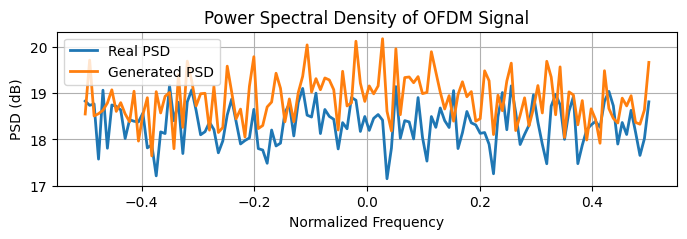

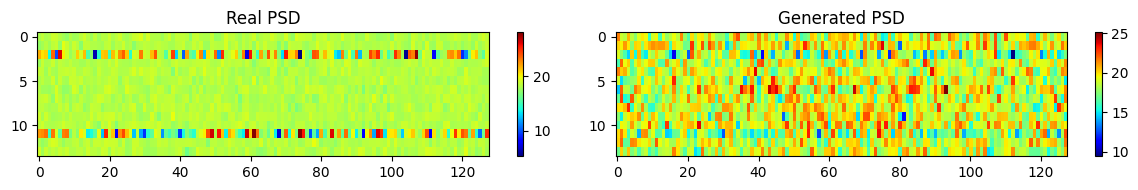

Epoch [1001/2000] w_d:-173.7226 gp: 55.6343, grad_norm: 3.3528 Loss_D: -118.0883 Loss_G: 466.9198, mse(PSD): 5.0833
Epoch [1002/2000] w_d:-166.4689 gp: 52.9985, grad_norm: 3.2944 Loss_D: -113.4705 Loss_G: 447.1382, mse(PSD): 4.7554
Epoch [1003/2000] w_d:-171.0257 gp: 52.3644, grad_norm: 3.2818 Loss_D: -118.6613 Loss_G: 467.1608, mse(PSD): 5.0469
Epoch [1004/2000] w_d:-166.5992 gp: 53.8214, grad_norm: 3.3109 Loss_D: -112.7778 Loss_G: 460.7553, mse(PSD): 5.0377
Epoch [1005/2000] w_d:-165.2272 gp: 51.8343, grad_norm: 3.2641 Loss_D: -113.3930 Loss_G: 449.6199, mse(PSD): 4.7076
Epoch [1006/2000] w_d:-168.3005 gp: 55.0951, grad_norm: 3.3408 Loss_D: -113.2054 Loss_G: 454.6515, mse(PSD): 4.6299
Epoch [1007/2000] w_d:-161.3214 gp: 51.4090, grad_norm: 3.2603 Loss_D: -109.9124 Loss_G: 445.4874, mse(PSD): 4.7631
Epoch [1008/2000] w_d:-160.8713 gp: 50.0293, grad_norm: 3.2296 Loss_D: -110.8420 Loss_G: 447.6028, mse(PSD): 4.7817
Epoch [1009/2000] w_d:-161.5456 gp: 51.0646, grad_norm: 3.2529 Loss_D: -

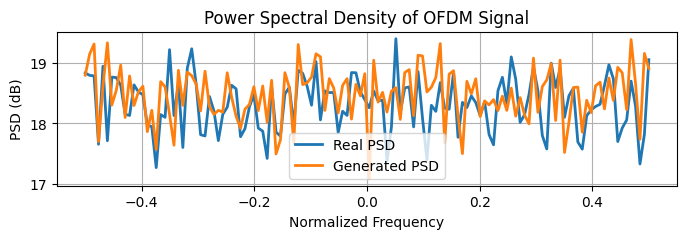

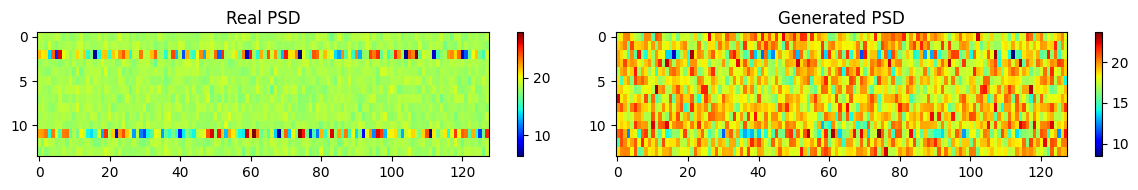

Epoch [1101/2000] w_d:-160.7861 gp: 48.9266, grad_norm: 3.2001 Loss_D: -111.8596 Loss_G: 580.6307, mse(PSD): 4.8145
Epoch [1102/2000] w_d:-167.4627 gp: 48.6900, grad_norm: 3.1965 Loss_D: -118.7727 Loss_G: 597.9597, mse(PSD): 4.8147
Epoch [1103/2000] w_d:-167.5050 gp: 54.2802, grad_norm: 3.3216 Loss_D: -113.2248 Loss_G: 587.3174, mse(PSD): 4.2818
Epoch [1104/2000] w_d:-165.0764 gp: 49.9273, grad_norm: 3.2244 Loss_D: -115.1491 Loss_G: 582.3345, mse(PSD): 5.1151
Epoch [1105/2000] w_d:-162.0008 gp: 50.1885, grad_norm: 3.2329 Loss_D: -111.8124 Loss_G: 577.0283, mse(PSD): 4.7574
Epoch [1106/2000] w_d:-162.5841 gp: 51.0985, grad_norm: 3.2523 Loss_D: -111.4857 Loss_G: 565.0638, mse(PSD): 4.6792
Epoch [1107/2000] w_d:-162.9824 gp: 50.3841, grad_norm: 3.2375 Loss_D: -112.5983 Loss_G: 578.5364, mse(PSD): 4.6961
Epoch [1108/2000] w_d:-161.0644 gp: 50.4452, grad_norm: 3.2386 Loss_D: -110.6192 Loss_G: 576.8778, mse(PSD): 4.6972
Epoch [1109/2000] w_d:-160.9194 gp: 48.7945, grad_norm: 3.2015 Loss_D: -

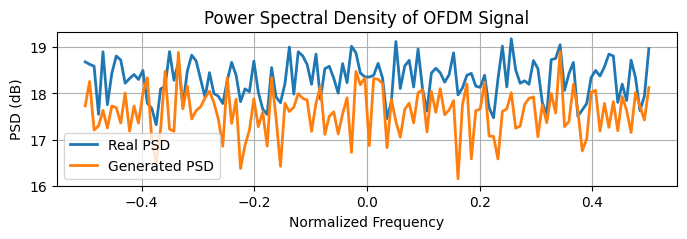

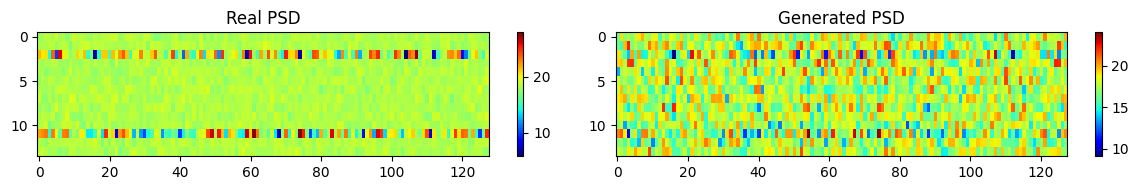

Epoch [1201/2000] w_d:-165.2455 gp: 50.9327, grad_norm: 3.2494 Loss_D: -114.3128 Loss_G: 744.6832, mse(PSD): 5.8198
Epoch [1202/2000] w_d:-164.1934 gp: 49.0890, grad_norm: 3.2063 Loss_D: -115.1044 Loss_G: 740.1464, mse(PSD): 5.3467
Epoch [1203/2000] w_d:-161.0428 gp: 49.0772, grad_norm: 3.2088 Loss_D: -111.9657 Loss_G: 748.3163, mse(PSD): 4.5057
Epoch [1204/2000] w_d:-162.2634 gp: 50.1144, grad_norm: 3.2258 Loss_D: -112.1491 Loss_G: 747.5061, mse(PSD): 4.7835
Epoch [1205/2000] w_d:-167.4082 gp: 49.2308, grad_norm: 3.2103 Loss_D: -118.1774 Loss_G: 758.6374, mse(PSD): 5.1659
Epoch [1206/2000] w_d:-166.0332 gp: 49.4064, grad_norm: 3.2158 Loss_D: -116.6268 Loss_G: 765.1870, mse(PSD): 4.5291
Epoch [1207/2000] w_d:-165.6910 gp: 51.1575, grad_norm: 3.2425 Loss_D: -114.5335 Loss_G: 752.3472, mse(PSD): 5.9992
Epoch [1208/2000] w_d:-167.8598 gp: 49.8244, grad_norm: 3.2263 Loss_D: -118.0354 Loss_G: 761.8999, mse(PSD): 5.2258
Epoch [1209/2000] w_d:-167.0670 gp: 51.7259, grad_norm: 3.2602 Loss_D: -

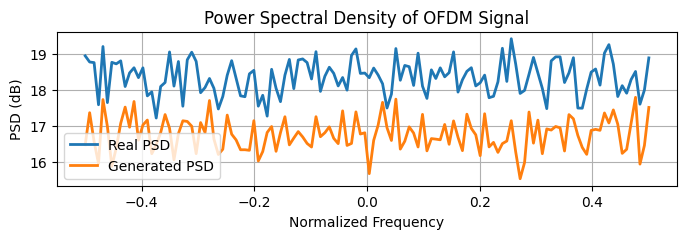

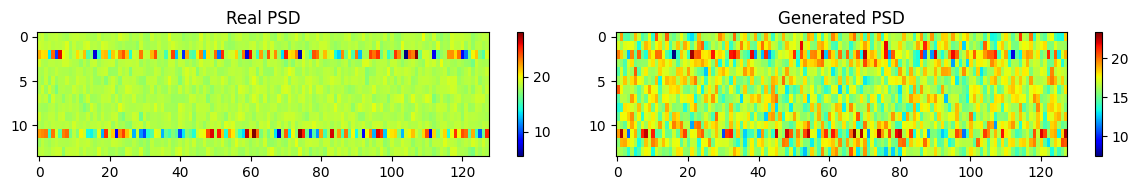

Epoch [1301/2000] w_d:-170.5429 gp: 50.3342, grad_norm: 3.2333 Loss_D: -120.2087 Loss_G: 841.7476, mse(PSD): 7.4449
Epoch [1302/2000] w_d:-167.5951 gp: 49.9268, grad_norm: 3.2260 Loss_D: -117.6683 Loss_G: 855.6193, mse(PSD): 7.9179
Epoch [1303/2000] w_d:-175.3690 gp: 56.0324, grad_norm: 3.3594 Loss_D: -119.3366 Loss_G: 852.3502, mse(PSD): 8.5157
Epoch [1304/2000] w_d:-178.7055 gp: 50.2886, grad_norm: 3.2331 Loss_D: -128.4169 Loss_G: 866.9802, mse(PSD): 5.8324
Epoch [1305/2000] w_d:-179.3506 gp: 53.1226, grad_norm: 3.2934 Loss_D: -126.2280 Loss_G: 855.9305, mse(PSD): 8.4036
Epoch [1306/2000] w_d:-179.1498 gp: 54.3801, grad_norm: 3.3213 Loss_D: -124.7697 Loss_G: 861.3355, mse(PSD): 6.4904
Epoch [1307/2000] w_d:-175.6407 gp: 51.9812, grad_norm: 3.2732 Loss_D: -123.6595 Loss_G: 868.6853, mse(PSD): 7.9315
Epoch [1308/2000] w_d:-168.3191 gp: 51.7627, grad_norm: 3.2703 Loss_D: -116.5564 Loss_G: 867.1735, mse(PSD): 7.0633
Epoch [1309/2000] w_d:-170.5653 gp: 50.6939, grad_norm: 3.2432 Loss_D: -

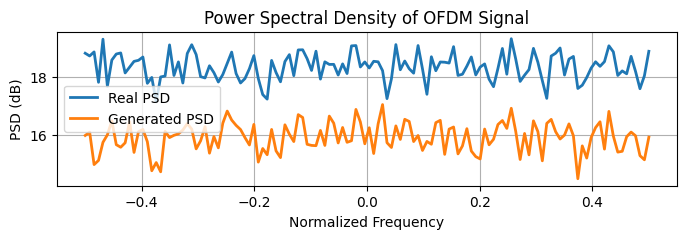

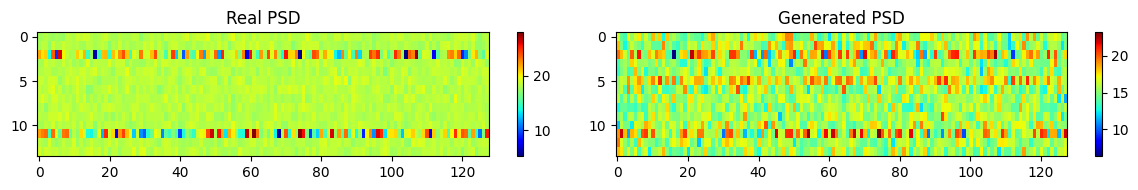

Epoch [1401/2000] w_d:-180.4407 gp: 53.0586, grad_norm: 3.2859 Loss_D: -127.3821 Loss_G: 938.3134, mse(PSD): 10.8819
Epoch [1402/2000] w_d:-181.2014 gp: 53.1030, grad_norm: 3.2851 Loss_D: -128.0984 Loss_G: 936.0931, mse(PSD): 8.6064
Epoch [1403/2000] w_d:-184.1995 gp: 50.1708, grad_norm: 3.2313 Loss_D: -134.0288 Loss_G: 948.9329, mse(PSD): 9.7943
Epoch [1404/2000] w_d:-185.3009 gp: 50.7091, grad_norm: 3.2405 Loss_D: -134.5918 Loss_G: 963.0083, mse(PSD): 9.7070
Epoch [1405/2000] w_d:-182.6618 gp: 61.7497, grad_norm: 3.3878 Loss_D: -120.9122 Loss_G: 931.7067, mse(PSD): 10.1297
Epoch [1406/2000] w_d:-181.6354 gp: 49.1252, grad_norm: 3.2066 Loss_D: -132.5102 Loss_G: 935.1956, mse(PSD): 9.6725
Epoch [1407/2000] w_d:-178.4161 gp: 48.9415, grad_norm: 3.2061 Loss_D: -129.4746 Loss_G: 953.2864, mse(PSD): 10.9876
Epoch [1408/2000] w_d:-175.5225 gp: 51.9206, grad_norm: 3.2708 Loss_D: -123.6019 Loss_G: 939.3810, mse(PSD): 9.5001
Epoch [1409/2000] w_d:-180.0341 gp: 47.4115, grad_norm: 3.1686 Loss_D

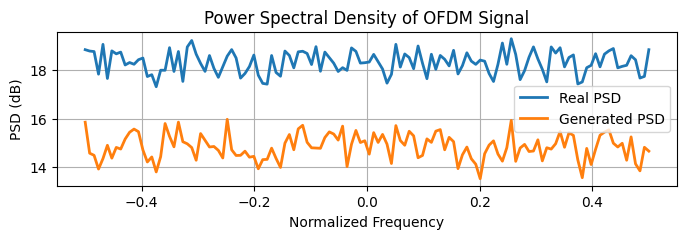

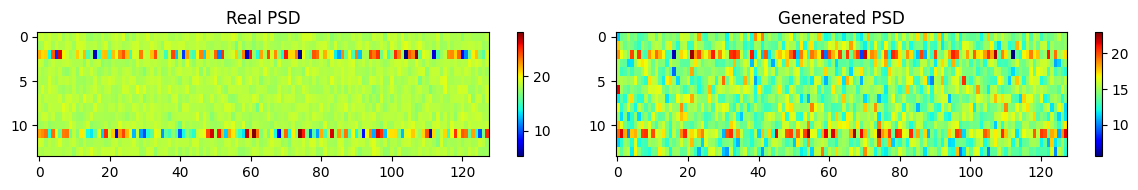

Epoch [1501/2000] w_d:-191.4341 gp: 61.3663, grad_norm: 3.4229 Loss_D: -130.0677 Loss_G: 1039.2461, mse(PSD): 14.7334
Epoch [1502/2000] w_d:-199.8253 gp: 55.6864, grad_norm: 3.3419 Loss_D: -144.1389 Loss_G: 1043.3822, mse(PSD): 17.8424
Epoch [1503/2000] w_d:-197.0999 gp: 59.5710, grad_norm: 3.4103 Loss_D: -137.5289 Loss_G: 1019.3915, mse(PSD): 18.6223
Epoch [1504/2000] w_d:-204.7947 gp: 58.1309, grad_norm: 3.3761 Loss_D: -146.6638 Loss_G: 1015.3571, mse(PSD): 17.7294
Epoch [1505/2000] w_d:-203.3916 gp: 54.0507, grad_norm: 3.2835 Loss_D: -149.3409 Loss_G: 1037.9559, mse(PSD): 15.5507
Epoch [1506/2000] w_d:-198.7706 gp: 54.9271, grad_norm: 3.3384 Loss_D: -143.8434 Loss_G: 1035.4841, mse(PSD): 16.5289
Epoch [1507/2000] w_d:-197.8827 gp: 54.3662, grad_norm: 3.3196 Loss_D: -143.5165 Loss_G: 1040.7719, mse(PSD): 18.0111
Epoch [1508/2000] w_d:-202.3188 gp: 57.3818, grad_norm: 3.3689 Loss_D: -144.9371 Loss_G: 1041.3674, mse(PSD): 18.2880
Epoch [1509/2000] w_d:-196.8295 gp: 53.6713, grad_norm: 

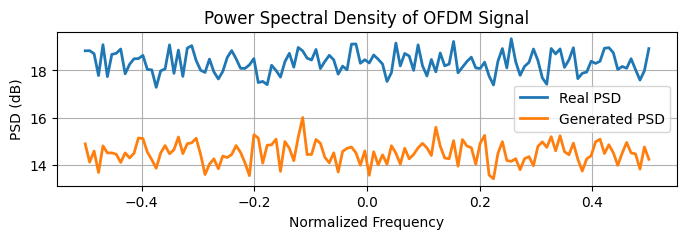

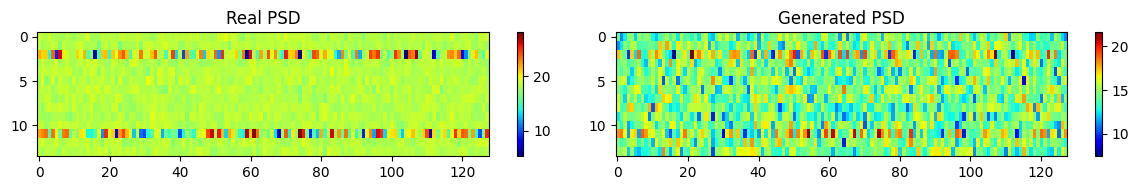

Epoch [1601/2000] w_d:-256.0911 gp: 61.0570, grad_norm: 3.4611 Loss_D: -195.0341 Loss_G: 1274.5298, mse(PSD): 16.1506
Epoch [1602/2000] w_d:-274.0862 gp: 67.5399, grad_norm: 3.5743 Loss_D: -206.5463 Loss_G: 1325.9564, mse(PSD): 14.8255
Epoch [1603/2000] w_d:-259.8838 gp: 66.0846, grad_norm: 3.5546 Loss_D: -193.7992 Loss_G: 1304.9966, mse(PSD): 13.7185
Epoch [1604/2000] w_d:-276.5761 gp: 61.7227, grad_norm: 3.4720 Loss_D: -214.8535 Loss_G: 1304.6729, mse(PSD): 15.3357
Epoch [1605/2000] w_d:-268.7649 gp: 66.3126, grad_norm: 3.5634 Loss_D: -202.4523 Loss_G: 1325.4944, mse(PSD): 13.6091
Epoch [1606/2000] w_d:-269.0360 gp: 67.8950, grad_norm: 3.5954 Loss_D: -201.1410 Loss_G: 1323.5464, mse(PSD): 14.8325
Epoch [1607/2000] w_d:-265.5164 gp: 71.7719, grad_norm: 3.6408 Loss_D: -193.7444 Loss_G: 1274.2345, mse(PSD): 19.4432
Epoch [1608/2000] w_d:-267.0090 gp: 66.4530, grad_norm: 3.5672 Loss_D: -200.5560 Loss_G: 1291.9819, mse(PSD): 18.7509
Epoch [1609/2000] w_d:-266.9108 gp: 65.9054, grad_norm: 

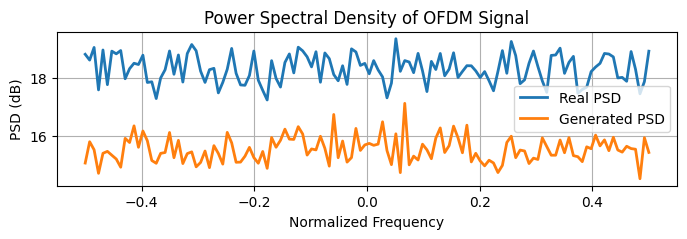

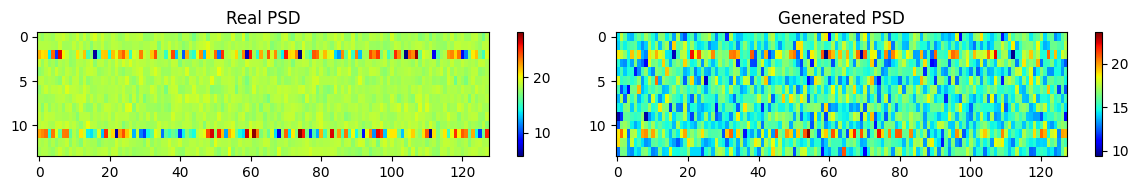

Epoch [1701/2000] w_d:-495.9240 gp: 92.0056, grad_norm: 4.0066 Loss_D: -403.9184 Loss_G: 1852.7471, mse(PSD): 12.0110
Epoch [1702/2000] w_d:-480.4081 gp: 93.0611, grad_norm: 3.9647 Loss_D: -387.3470 Loss_G: 1765.5168, mse(PSD): 12.0231
Epoch [1703/2000] w_d:-524.4270 gp: 87.0984, grad_norm: 3.9240 Loss_D: -437.3286 Loss_G: 1926.1510, mse(PSD): 12.6156
Epoch [1704/2000] w_d:-564.2863 gp: 87.3956, grad_norm: 3.9157 Loss_D: -476.8906 Loss_G: 1949.3328, mse(PSD): 14.1122
Epoch [1705/2000] w_d:-529.2106 gp: 101.7152, grad_norm: 4.1142 Loss_D: -427.4954 Loss_G: 1903.1219, mse(PSD): 13.4213
Epoch [1706/2000] w_d:-542.8162 gp: 88.4983, grad_norm: 3.9514 Loss_D: -454.3178 Loss_G: 1902.9666, mse(PSD): 13.3550
Epoch [1707/2000] w_d:-506.6298 gp: 86.8105, grad_norm: 3.9032 Loss_D: -419.8192 Loss_G: 1899.7596, mse(PSD): 14.1276
Epoch [1708/2000] w_d:-590.6920 gp: 96.0547, grad_norm: 4.0395 Loss_D: -494.6373 Loss_G: 2036.3593, mse(PSD): 10.4209
Epoch [1709/2000] w_d:-547.3481 gp: 88.7917, grad_norm:

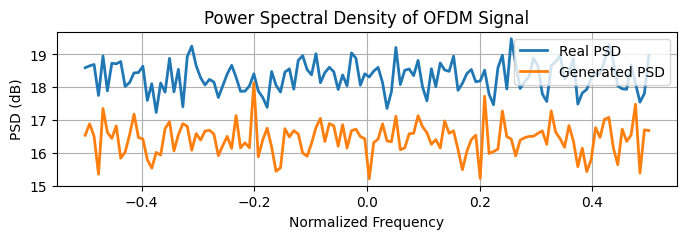

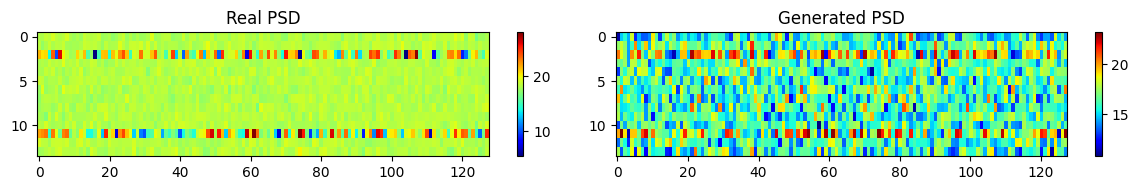

Epoch [1801/2000] w_d:-1453.0161 gp: 150.0836, grad_norm: 4.7181 Loss_D: -1302.9325 Loss_G: 4045.6396, mse(PSD): 8.4614
Epoch [1802/2000] w_d:-1332.4011 gp: 160.9925, grad_norm: 4.9599 Loss_D: -1171.4086 Loss_G: 3971.2622, mse(PSD): 9.2441
Epoch [1803/2000] w_d:-1371.5688 gp: 139.6393, grad_norm: 4.6189 Loss_D: -1231.9296 Loss_G: 4011.2964, mse(PSD): 8.5650
Epoch [1804/2000] w_d:-1431.7209 gp: 160.8541, grad_norm: 4.9384 Loss_D: -1270.8668 Loss_G: 4110.0503, mse(PSD): 8.8150
Epoch [1805/2000] w_d:-1411.1985 gp: 150.9128, grad_norm: 4.7808 Loss_D: -1260.2856 Loss_G: 4050.8752, mse(PSD): 8.2114
Epoch [1806/2000] w_d:-1323.4858 gp: 147.3790, grad_norm: 4.7298 Loss_D: -1176.1069 Loss_G: 4133.9004, mse(PSD): 11.5657
Epoch [1807/2000] w_d:-1375.3906 gp: 145.3592, grad_norm: 4.6668 Loss_D: -1230.0315 Loss_G: 4208.4644, mse(PSD): 9.1369
Epoch [1808/2000] w_d:-1446.6311 gp: 183.7469, grad_norm: 5.1997 Loss_D: -1262.8843 Loss_G: 4267.6494, mse(PSD): 9.9930
Epoch [1809/2000] w_d:-1407.8120 gp: 18

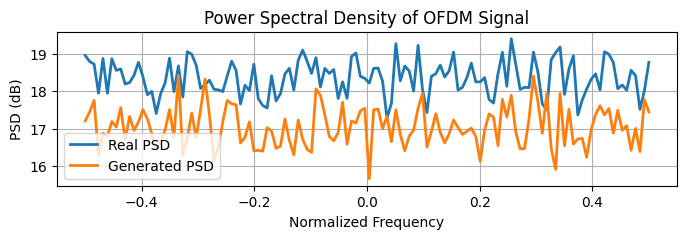

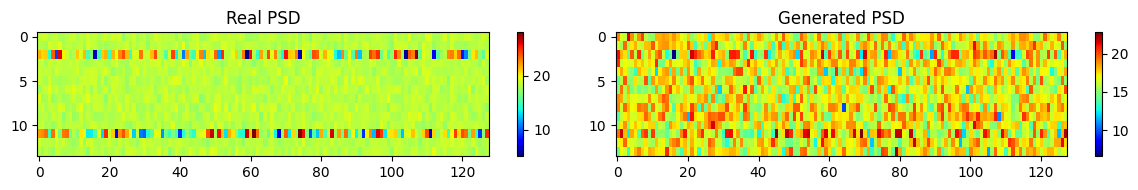

Epoch [1901/2000] w_d:-2371.5889 gp: 220.1707, grad_norm: 5.5430 Loss_D: -2151.4182 Loss_G: 6800.3662, mse(PSD): 5.7241
Epoch [1902/2000] w_d:-2778.4980 gp: 248.2584, grad_norm: 5.8292 Loss_D: -2530.2397 Loss_G: 7559.3765, mse(PSD): 6.1730
Epoch [1903/2000] w_d:-2902.3081 gp: 244.1782, grad_norm: 5.8452 Loss_D: -2658.1299 Loss_G: 7657.0898, mse(PSD): 5.4373
Epoch [1904/2000] w_d:-2421.3081 gp: 272.6120, grad_norm: 5.7591 Loss_D: -2148.6960 Loss_G: 7185.6289, mse(PSD): 5.0179
Epoch [1905/2000] w_d:-2747.7520 gp: 249.6436, grad_norm: 5.7836 Loss_D: -2498.1084 Loss_G: 7384.2231, mse(PSD): 5.3968
Epoch [1906/2000] w_d:-2530.0713 gp: 240.6285, grad_norm: 5.8452 Loss_D: -2289.4429 Loss_G: 7321.3105, mse(PSD): 7.5003
Epoch [1907/2000] w_d:-2750.9917 gp: 239.5174, grad_norm: 5.8065 Loss_D: -2511.4744 Loss_G: 7352.9014, mse(PSD): 5.4346
Epoch [1908/2000] w_d:-2725.2476 gp: 268.1781, grad_norm: 6.0045 Loss_D: -2457.0696 Loss_G: 7377.9858, mse(PSD): 5.8698
Epoch [1909/2000] w_d:-2618.7773 gp: 231

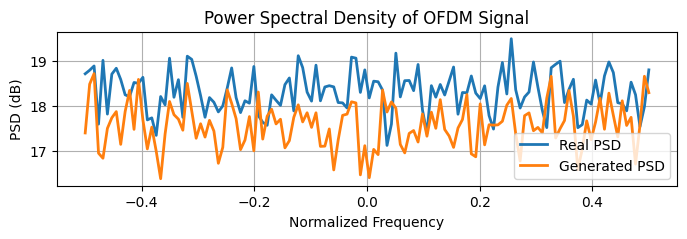

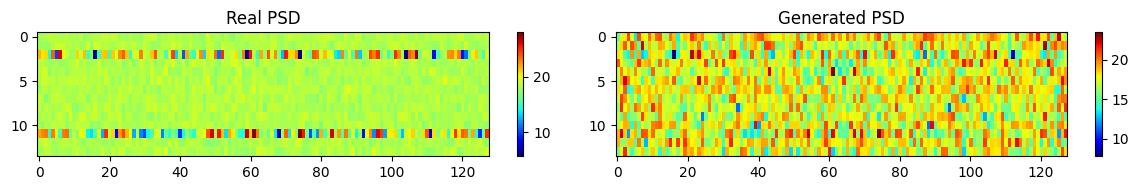

In [41]:
offset=1000

for i in tqdm(range(offset, epoch*2+1)):    
    # Sampling a batch of SNRs
    # ebno_db = tf.random.uniform(shape=[], minval=ebno_db_min, maxval=ebno_db_max)
    ebno_db = tf.constant(10.0, tf.float32)
    
    _, x_rg, _, y_real = model(batch_size, ebno_db, use_gan_channel=True)
    d_real, d_fake, loss_D, loss_G, gp, grad_norm, y_fake = WGAN_train_step(y_real, x_rg) 
    
    gan_weights_G = WG.get_weights()
    gan_weights_D = WD.get_weights()

    # -----------------------------------------------------------------------     
    list_D.append(loss_D)
    list_G.append(loss_G)
    psd_real = compute_psd(y_real) # psd averaged over batch and 14 ofdm -> fft psd
    psd_generated = compute_psd(y_fake)
    mse_psd = tf.reduce_mean((psd_real - psd_generated)**2)

    print(f"Epoch [{i}/{epoch*2}] w_d:{loss_D.numpy()-gp.numpy():.4f} gp: {gp.numpy():.4f}, grad_norm: {grad_norm.numpy():.4f} Loss_D: {loss_D.numpy():.4f} Loss_G: {loss_G.numpy():.4f}, mse(PSD): {mse_psd.numpy():.4f}") 

    if i % 100 == 0:
        psd_real_line = compute_psd_line(y_real) 
        psd_generated_line = compute_psd_line(y_fake)
        plot_psd_line(psd_real_line, psd_generated_line)
        plot_psd(psd_real, psd_generated)

        with open(f'y_output/train_generated_y_{i}.txt', 'w') as f:
            np.savetxt(f, y_fake.numpy().reshape(-1), fmt='%.6f')
        with open(f'y_output/train_real_y_{i}.txt', 'w') as f:
            np.savetxt(f, y_real.numpy().reshape(-1), fmt='%.6f')
    
    if i % 500 == 0:
        # save GAN weights
        with open(f'gan_weights/gan_weights_G_{i}.pkl', 'wb') as f2:
            pickle.dump(gan_weights_G, f2)
        with open(f'gan_weights/gan_weights_D_{i}.pkl', 'wb') as f3:
                pickle.dump(gan_weights_D, f3)

## Training Nerual Transmitter and Receiver <a class="anchor" id="Training-the-Neural-Receiver"></a>

In [ ]:
# model(1, tf.constant(10.0, tf.float32), use_gan_channel=True)
# model.summary()
eval_model(1, tf.constant(10.0, tf.float32), use_gan_channel=False)
# eval_model.summary()
e_weights = eval_model.trainable_weights
for w in e_weights:
    print(f"Layer: {w.name}, Shape: {w.shape}")

In [ ]:
# for layer in model.layers:
#     if isinstance(layer, NeuralReceiver):
#         layer.trainable = True  # Ensure the receiver is trainable
#     else:
#         layer.trainable = False  # Freeze all other layers
for layer in model.layers:
        layer.trainable = True
weights = model.trainable_weights
for w in weights:
    print(f"Layer: {w.name}, Shape: {w.shape}")

In [46]:
optimizer = tf.keras.optimizers.legacy.Adam()

@tf.function
def E2E_train__tx_step(ebno_db):
    for layer in model.layers:
        if isinstance(layer, (Constellation, Mapper)):
            layer.trainable = True  
        else:
            layer.trainable = False  
    tx_weights = model.trainable_weights
    # for w in tx_weights:
    #     print(f"Layer: {w.name}, Shape: {w.shape}")
    
    with tf.GradientTape() as tape:
        rate, _, y_gen, y_real, h_freq = model(training_batch_size, ebno_db, use_gan_channel=True)
        loss = -rate 
    
    grads_tx = tape.gradient(loss, tx_weights)
    optimizer.apply_gradients(zip(grads_tx, tx_weights))
    
    return loss, y_gen, y_real

@tf.function
def E2E_train__rx_step(ebno_db):
    for layer in model.layers:
        if isinstance(layer, NeuralReceiver):
            layer.trainable = True 
        else:
            layer.trainable = False
    rx_weights = model.trainable_weights
    # for w in rx_weights:
    #     print(f"Layer: {w.name}, Shape: {w.shape}")
    
    with tf.GradientTape() as tape:
        rate = model(training_batch_size, ebno_db, use_gan_channel=False)
        loss = -rate 
    
    grads_rx = tape.gradient(loss, rx_weights)
    optimizer.apply_gradients(zip(grads_rx, rx_weights))

    return loss

In [ ]:
offset = 0
model = E2ESystem(training=True)
eval_model = E2ESystem(training=False)
model(training_batch_size, ebno_db, use_gan_channel=False)
# with open('weights_trained/model_weights_50000.pkl', 'rb') as f:
#     weights = pickle.load(f)
# model.set_weights(weights)  
with open('ofdm_wgan_weights_G_conv2d_3000.pkl', 'rb') as f:
    gan_weights_G = pickle.load(f)
model._gan_channel.set_weights(gan_weights_G)

# -----------------------------------------------------------------
for i in tqdm(range(offset, num_training_iterations+1)): 
    ebno_db = tf.random.uniform(shape=[], minval=ebno_db_min, maxval=ebno_db_max)
    
    loss_tx, y_gen, y_real = E2E_train__tx_step(ebno_db)

    if i % 1000 == 0:
        with open(f'y_output/tx_generated_y_{i}.txt', 'w') as f1:
            np.savetxt(f1, y_gen.numpy().reshape(-1), fmt='%.6f')
        with open(f'y_output/tx_real_y_{i}.txt', 'w') as f2:
            np.savetxt(f2, y_real.numpy().reshape(-1), fmt='%.6f')
    
    loss_rx = E2E_train__rx_step(ebno_db)
     
    for layer in model.layers:
        layer.trainable = True
    weights = model.get_weights()
        
    if i % 100 == 0:
        log_str = f"Iteration {i}/{num_training_iterations}, Eb/No: {ebno_db.numpy():.4f}, Loss_tx: {loss_tx.numpy():.4f}, Loss_rx: {loss_rx.numpy():.4f}"
        print(log_str)
        
        eval_model(1, tf.constant(10.0, tf.float32), use_gan_channel=False)
        eval_model.set_weights(weights)
        # validation at 3.5dB
        ber, bler = sim_ber(eval_model, [3.5], batch_size=128, num_target_block_errors=50, max_mc_iter=200) 

    if i % 5000 == 0:
        with open(f'weights_trained/model_weights_{i}.pkl', 'wb') as f:
            pickle.dump(weights, f)

# Save the weights in a file
weights = model.get_weights()
with open(model_weights_path_trained, 'wb') as f:
    pickle.dump(weights, f)

  0%|          | 0/50001 [00:00<?, ?it/s]

Iteration 0/50000, Eb/No: 5.0915, Loss_tx: 0.6268, Loss_rx: 0.6393
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      3.5 | 4.9995e-01 | 1.0000e+00 |      267237 |      534528 |          128 |         128 |         0.4 |reached target block errors
Iteration 100/50000, Eb/No: 5.8227, Loss_tx: -0.0144, Loss_rx: -0.0143
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      3.5 | 4.8278e-01 | 1.0000e+00 |      258060 |      534528 |          128 |         128 |         0.3 |reached target block errors
Iteration 200/50000, Eb/No: 6.7556, Loss_tx: -0.1171, Loss_rx: -0.1208
EbNo [dB]

## Joint training

In [ ]:
for i in tqdm(range(offset, num_training_iterations+1)):    
    # Sampling a batch of SNRs
    ebno_db = tf.constant(10.0, tf.float32)
    
    _, x_rg, _, y_real, h_freq = model(batch_size, ebno_db, use_gan_channel=True)
    d_real, d_fake, loss_D, loss_G, gp, grad_norm, y_fake = WGAN_train_step(y_real, x_rg, h_freq) 
    
    gan_weights_G = WG.get_weights()
    gan_weights_D = WD.get_weights()

    # -----------------------------------------------------------------------
    if i % 100 == 0:
        print(f"Epoch [{i}/{epoch}] w_d:{loss_D.numpy()-gp.numpy():.4f} gp: {gp.numpy():.4f}, grad_norm: {grad_norm.numpy():.4f} Loss_D: {loss_D.numpy():.4f} Loss_G: {loss_G.numpy():.4f}, mse(PSD): {mse_psd.numpy():.4f}") 
    
        if i % 500 == 0:
            with open(f'y_output/train_generated_y_{i}.txt', 'w') as f:
                np.savetxt(f, y_rg_fake.numpy().reshape(-1), fmt='%.6f')
            with open(f'y_output/train_real_y_{i}.txt', 'w') as f:
                np.savetxt(f, y_real.numpy().reshape(-1), fmt='%.6f')
            # save GAN weights
            with open(f'gan_weights/gan_weights_G_{i}.pkl', 'wb') as f2:
                pickle.dump(gan_weights_G, f2)
            with open(f'gan_weights/gan_weights_D_{i}.pkl', 'wb') as f3:
                    pickle.dump(gan_weights_D, f3)

    # -----------------------------------------------------------------------
    model._gan_channel.set_weights(gan_weights_G)
    
    loss_tx, y_gen, y_real = E2E_train__tx_step(ebno_db)

    if i % 500 == 0:
        with open(f'y_output/tx_generated_y_{i}.txt', 'w') as f1:
            np.savetxt(f1, y_gen.numpy().reshape(-1), fmt='%.6f')
        with open(f'y_output/tx_real_y_{i}.txt', 'w') as f2:
            np.savetxt(f2, y_real.numpy().reshape(-1), fmt='%.6f')
    
    loss_rx = E2E_train__rx_step(ebno_db)
     
    for layer in model.layers:
        layer.trainable = True
    weights = model.get_weights()
        
    if i % 500 == 0:
        log_str = f"Iteration {i}/{num_training_iterations}, Eb/No: {ebno_db.numpy():.4f}, Loss_tx: {loss_tx.numpy():.4f}, Loss_rx: {loss_rx.numpy():.4f}"
        print(log_str)
        
        with open(f'weights_trained/model_weights_{i}.pkl', 'wb') as f:
            pickle.dump(weights, f)

        eval_model(1, tf.constant(10.0, tf.float32), use_gan_channel=False)
        eval_model.set_weights(weights)
        
        # validation at 3.5dB
        ber, bler = sim_ber(eval_model, [3.5], batch_size=128, num_target_block_errors=50, max_mc_iter=200)
        validation_log_str = f"Iteration {i}/{num_training_iterations}: BER = {ber.numpy()}, BLER = {bler.numpy()}"
        print(validation_log_str) 

# Save the weights in a file
weights = model.get_weights()
with open(model_weights_path_trained, 'wb') as f:
    pickle.dump(weights, f)

## Learned Constellation <a class="anchor" id="Constellation"></a>

In [ ]:
# Utility function to load and set weights of a mode
def load_weights(model, model_weights_path):
    model(1, tf.constant(10.0, tf.float32))
    with open(model_weights_path, 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)
    
model = E2ESystem('neural-receiver-trained', training=True)
load_weights(model, model_weights_path_trained)

# fig = model.constellation.show()
constellation = model.constellation
figsize=(10,10)
maxval = np.max(np.abs(constellation.points))*1.05
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
plt.xlim(-maxval, maxval)
plt.ylim(-maxval, maxval)
plt.scatter(np.real(constellation.points), np.imag(constellation.points))
ax.set_aspect("equal", adjustable="box")
plt.grid(True, which="both", axis="both")
plt.title("Trained mapper")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
for j, p in enumerate(constellation.points):
    plt.annotate(
        np.binary_repr(j, num_bits_per_symbol),
        (np.real(p), np.imag(p))
    )

## Evaluation of the Neural Receiver <a class="anchor" id="Evaluation-of-the-Neural-Receiver"></a>

In [27]:
eval_model = E2ESystem(training=False)
with open('weights_trained/model_weights_100000.pkl', 'rb') as f:
    weights = pickle.load(f)
eval_model(1, tf.constant(10.0, tf.float32), use_gan_channel=False)
eval_model.set_weights(weights)

# Evaluations
ber,bler = sim_ber(eval_model, ebno_dbs, batch_size=128, num_target_block_errors=50, max_mc_iter=9000)
BLER['neural-receiver-gan-trained'] = bler.numpy()
BER['neural-receiver-gan-trained'] = ber.numpy()

with open(results_filename, 'wb') as f:
    pickle.dump((ebno_dbs, BLER, BER), f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.0247e-01 | 1.0000e+00 |      108228 |      534528 |          128 |         128 |         0.4 |reached target block errors
      0.5 | 1.8547e-01 | 1.0000e+00 |       99140 |      534528 |          128 |         128 |         0.3 |reached target block errors
      1.0 | 1.6764e-01 | 1.0000e+00 |       89607 |      534528 |          128 |         128 |         0.3 |reached target block errors
      1.5 | 1.3882e-01 | 1.0000e+00 |       74204 |      534528 |          128 |         128 |         0.3 |reached target block errors
      2.0 | 7.9143e-02 | 1.0000e+00 |       42304 |      534528 |          128 |         128 |         0.3 |reached target block errors
      2.5 | 1.2284e-02 | 6.0938e-01 |        6566 |      534528 |

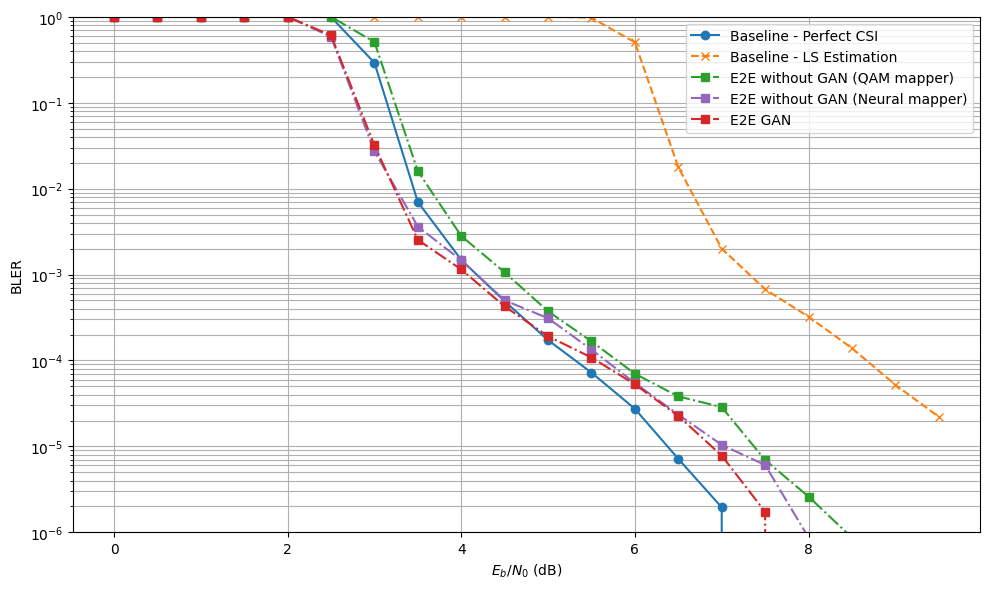

In [32]:
plt.figure(figsize=(10,6))

with open('neural_receiver_results_300000_9000', 'rb') as file: 
        ebno_dbs, BLER, BER = pickle.load(file)
BER_st = BER
BLER_st = BLER
with open(results_filename, 'rb') as file: 
        ebno_dbs, BLER, BER = pickle.load(file)
BER_g = BER
BLER_g = BLER

plt.semilogy(ebno_dbs, BLER_st['baseline-perfect-csi'], 'o-', c=f'C0', label=f'Baseline - Perfect CSI')
plt.semilogy(ebno_dbs, BLER_st['baseline-ls-estimation'], 'x--', c=f'C1', label=f'Baseline - LS Estimation')
plt.semilogy(ebno_dbs, BLER_st['neural-receiver-standard'], 's-.', c=f'C2', label=f'E2E without GAN (QAM mapper)')
plt.semilogy(ebno_dbs, BLER_st['neural-receiver-trained'], 's-.', c=f'C4', label=f'E2E without GAN (Neural mapper)')
plt.semilogy(ebno_dbs, BLER_g['neural-receiver-gan-trained'], 's-.', c=f'C3', label=f'E2E GAN')

plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")
plt.ylim((1e-6, 1.0))
plt.legend()
plt.tight_layout()

Model: "e2e_system_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 binary_source_58 (BinarySo  multiple                  0         
 urce)                                                           
                                                                 
 ldpc5g_encoder_31 (LDPC5GE  multiple                  0         
 ncoder)                                                         
                                                                 
 constellation_58 (Constell  multiple                  128       
 ation)                                                          
                                                                 
 mapper_58 (Mapper)          multiple                  128       
                                                                 
 resource_grid_mapper_57 (R  multiple                  0         
 esourceGridMapper)                                  

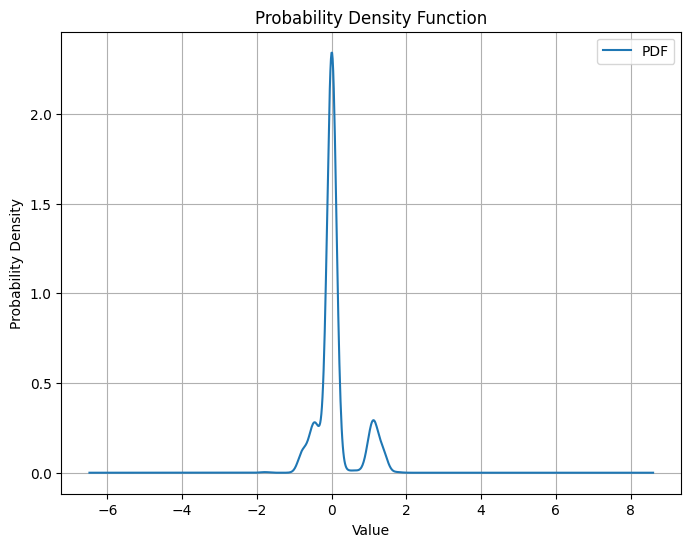

In [57]:
from scipy.stats import gaussian_kde

model = E2ESystem('neural-receiver-trained', use_gan_channel=True)
eval_model = E2ESystem('neural-receiver-trained')

model(1, tf.constant(10.0, tf.float32))
with open(model_weights_path_trained, 'rb') as f:
    weights = pickle.load(f)
model.set_weights(weights)

eval_model(1, tf.constant(10.0, tf.float32))
names = [w.name for w in model.trainable_weights]
eval_weights = [weight for name, weight in zip(names, weights) if "gan_channel" not in name]
eval_model.set_weights(eval_weights)

model.summary()
eval_model.summary()

nn_para = np.zeros(1)
for layer in model.layers:
    for weight in layer.weights:
        nn_para = np.concatenate((nn_para, weight.numpy().reshape(-1)), axis=0)

# Gaussian kernel density estimate
data = nn_para  # Replace with your data
kde = gaussian_kde(data[0:1000])

x = np.linspace(min(data), max(data), 1000)

plt.figure(figsize=(8, 6))
plt.plot(x, kde(x), label='PDF')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Probability Density Function')
plt.legend()
plt.grid(True)
plt.show()

## References <a class="anchor" id="References"></a>

[1] M. Honkala, D. Korpi and J. M. J. Huttunen, "DeepRx: Fully Convolutional Deep Learning Receiver," in IEEE Transactions on Wireless Communications, vol. 20, no. 6, pp. 3925-3940, June 2021, doi: 10.1109/TWC.2021.3054520.

[2] F. Ait Aoudia and J. Hoydis, "End-to-end Learning for OFDM: From Neural Receivers to Pilotless Communication," in IEEE Transactions on Wireless Communications, doi: 10.1109/TWC.2021.3101364.

[3] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, "Deep Residual Learning for Image Recognition", Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2016, pp. 770-778

[4] G. Böcherer, "Achievable Rates for Probabilistic Shaping", arXiv:1707.01134, 2017.